In [51]:
# !pip install sciann fteikpy pyDOE -q 

In [52]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [53]:
ROOT_PATH = "EnDeepONet-OpenFWI"

In [54]:
RECEIVER_SIZE = 30
SENSOR_SIZE = 14*14
SOURCE_RADI = 0.
VMIN = 0.2
VMAX = 8.0
EPOCHS_MAX = 20000

In [55]:
import numpy as np
import sciann as sn 

import itertools
from functools import partial
# from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

In [56]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [57]:
# Download OpenFWI dataset to your local directory
# https://drive.google.com/drive/folders/1QTDno4_qed94mqhxJRzqWC19iYfANRqD
vel_models_path = "/Path/TO/CurveFault_B/"
vel_models_list = list(filter(lambda x: x.startswith('vel'), sorted(os.listdir(vel_models_path))))
vel_models = np.load(os.path.join(vel_models_path, vel_models_list[0])) / 1000

In [58]:
vel_models.shape

(500, 1, 70, 70)

In [59]:
INDEXING = 'ij'

In [60]:
DL = 0.050 #km
XMIN, XMAX = 0, 70*DL
YMIN, YMAX = 0, 70*DL
DELTAX = XMAX - XMIN
DELTAY = YMAX - YMIN

In [61]:
XGRID, YGRID = np.meshgrid(np.linspace(XMIN, XMAX, 70),
                           np.linspace(YMIN, YMAX, 70),
                           indexing=INDEXING)

def interpolate_velocity_model(Vs, Xs, Ys, method='nearest'):
    crd = np.hstack([XGRID.reshape(-1,1), YGRID.reshape(-1,1)])
    Vs = griddata(crd, Vs.flatten(), (Xs, Ys), method=method)
    return Vs.reshape(Xs.shape)

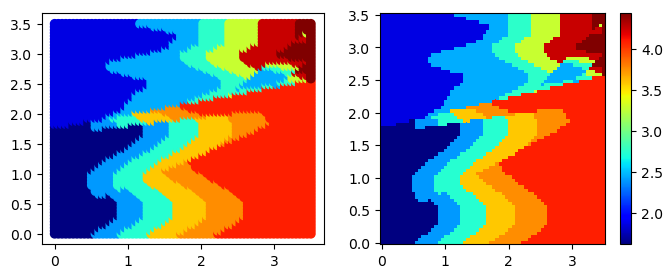

In [62]:
xgrid, ygrid = np.meshgrid(np.linspace(XMIN, XMAX, 70),
                           np.linspace(YMIN, YMAX, 70),
                           indexing=INDEXING)

vgrid = interpolate_velocity_model(vel_models[0, 0], xgrid, ygrid, 'nearest') #[:, ::-1]


fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].scatter(xgrid.flatten(), ygrid.flatten(), c=vel_models[0, 0].flatten(), cmap='jet')
# ax[0].invert_yaxis()
plt.colorbar(
    ax[1].pcolor(XGRID, YGRID, vel_models[0, 0], cmap='jet')
    # ax[1].imshow(vel_models[0, 0], cmap='seismic')
)
# ax[1].invert_yaxis()
# ax[1].invert_xaxis()
plt.show()

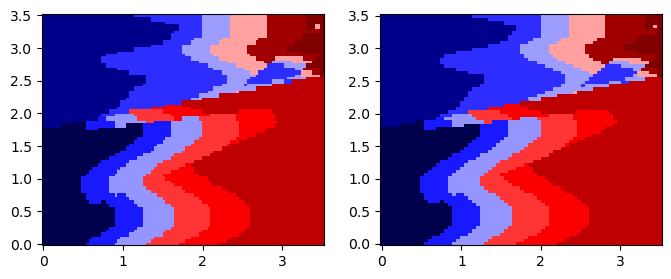

In [63]:
xgrid, ygrid = np.meshgrid(np.linspace(XMIN, XMAX, 100),
                           np.linspace(YMIN, YMAX, 100),
                           indexing=INDEXING)

vgrid = interpolate_velocity_model(vel_models[0, 0], xgrid, ygrid, 'nearest')

fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].pcolor(xgrid, ygrid, vgrid, cmap='seismic')
# ax[0].invert_yaxis()
ax[1].pcolor(XGRID, YGRID, vel_models[0, 0], cmap='seismic')
plt.show()

# Testing different velocity models 

In [64]:
import skfmm
from scipy.interpolate import griddata

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), \
                 (yd[1]-yd[0])/(Ny)
        sx, sy = np.round((source[0] - xd[0])/dx).astype(int), \
                 np.round((source[1] - yd[0])/dy).astype(int)
        phi = np.ones_like(vel)
        phi[sx, sy] = -1
        self.nx = (Nx+1, Ny+1)
        self.xg = np.meshgrid(np.linspace(xd[0], xd[1], Nx+1),
                              np.linspace(yd[0], yd[1], Ny+1),
                              indexing=INDEXING)
        self.dx = (dx, dy)
        self.vg = vel
        self.Tg = skfmm.travel_time(phi,vel,dx=(dx, dy),order=2)
        
    def __call__(self, xs=0., ys=0.):
        crd = np.hstack([self.xg[0].reshape(-1,1), self.xg[1].reshape(-1,1)])
        ts = griddata(crd, self.Tg.flatten(), (xs, ys), method='nearest')
        return ts.reshape(xs.shape)
    
    @property
    def grid(self):
        return self.Tg
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.Tg)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

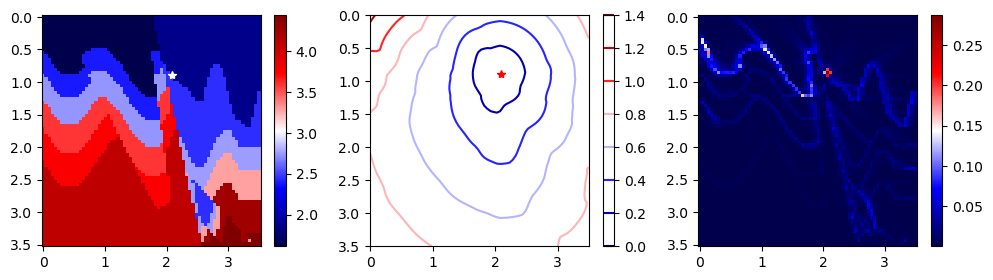

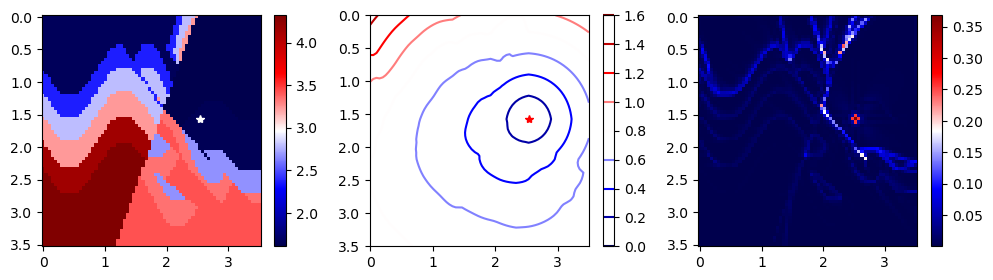

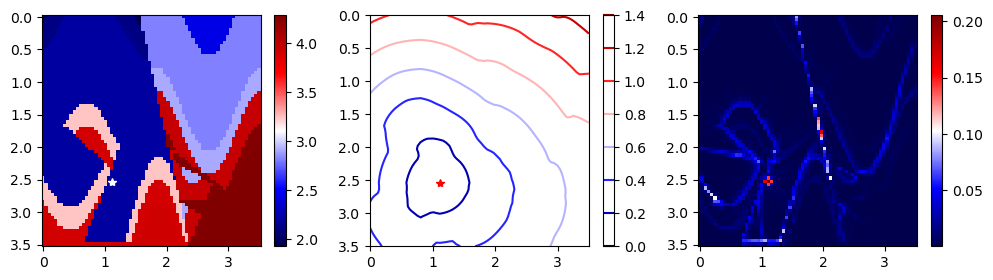

In [66]:

for i in range(3):
    v = vel_models[i, 0]
    xs = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
    ys = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)
    
    eik = EikonalSolver(vel=v, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[xs, ys])
    t = eik.grid
    x, y = eik.xg
    gt = eik.grad 
    res = abs(gt[0]**2 + gt[1]**2 - 1/v**2)

    fig, ax = plt.subplots(1,3,figsize=(12,3))
    plt.colorbar(
        ax[0].pcolor(x, y, v.T, cmap='seismic'), ax=ax[0]
    )
    ax[0].plot(ys, xs, '*w')
    plt.colorbar(
        ax[1].contour(x, y, t.T, cmap='seismic'), ax=ax[1]
    )
    ax[1].plot(ys, xs, '*r')
    plt.colorbar(
        ax[2].pcolor(x, y, res.T, cmap='seismic'), ax=ax[2]
    )
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[2].invert_yaxis()
    plt.show()

In [67]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [68]:
from tensorflow.keras.utils import Sequence 
from collections import OrderedDict


class DataGenerator(Sequence):
    def __init__(self, num_sample = 100,
                       sample_size = 10, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       recevier_size = 10,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._num_sample = num_sample
        self._sample_size = sample_size
        self._batch_size = batch_size
        
        self._sensor_size = sensor_size
        sensor_size_1d = int(np.sqrt(self._sensor_size) + 0.001)
        grid_1d_x = np.linspace(XMIN, XMAX, sensor_size_1d + 2)[1:-1]
        grid_1d_y = np.linspace(YMIN, YMAX, sensor_size_1d + 2)[1:-1]
        self._sensor = [gi.flatten() for gi in np.meshgrid(grid_1d_x, grid_1d_y)]
        
        self._recevier_size = recevier_size
        self._receiver = [np.linspace(XMIN, XMAX, recevier_size+2)[1:-1], 
                          np.full(recevier_size, YMAX)]
        
        self._shuffle = shuffle
        self._epoch = 1
        self._time = time.time()
        self._velocity_ids = np.arange(0, num_sample, dtype=int)
        # self._velocity_ids = np.random.choice(len(vel_models), sample_size, replace=False)
        self._vel_ratio = 1.0
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return int((self._num_sample - 1) / self._sample_size) + 1

    def __getitem__(self, index):
        start = index * self._sample_size
        end = min(start + self._sample_size, self._num_sample)
        idx = np.hstack(self._sample_ids[start:end])
        inputs = [xs[idx] for xs in self.inputs]
        outputs = [ys[idx] for ys in self.targets]
        sample_weights = [ws[idx] for ws in self.sample_weights]
        return inputs, outputs, sample_weights

    def get_sample(self, index):
        idx = self._sample_ids[index]
        inputs = [xs[idx] for xs in self.inputs]
        outputs = [ys[idx] for ys in self.targets]
        sample_weights = [ws[idx] for ws in self.sample_weights]
        return inputs, outputs, sample_weights
    
    def on_epoch_end(self):
        if self._epoch % 100 == 0:
            # self._vel_ratio = min(1, self._vel_ratio + 0.01)
            print(f"{self._epoch} - {self._time - time.time()}s - data updated with vel-ratio = {self._vel_ratio} ")
            # self._set_data()
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._num_sample, self._batch_size
        inputs = OrderedDict()
        targets = OrderedDict()
        sample_weights = OrderedDict()
        sample_ids = []
        total_sample_size = 0
        for i, idx in enumerate(self._velocity_ids):
            x_source = np.random.uniform(XMIN+0.05*DELTAX, XMAX-0.05*DELTAX)
            y_source = np.random.uniform(YMIN+0.05*DELTAY, YMAX-0.05*DELTAY)
            sample_velocity = vel_models[idx, 0]
            # scheduled_velocity = (sample_velocity - sample_velocity.mean()) * self._vel_ratio + sample_velocity.mean()
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(
                x_source, y_source, sample_velocity, batch_size)
            num_sample_i = inputs_i[0].shape[0]
            for i_xs, xs in enumerate(inputs_i):
                if i_xs not in inputs:
                    inputs[i_xs] = []
                inputs[i_xs].append(xs)
            for i_ys, ys in enumerate(targets_i):
                if i_ys not in targets:
                    targets[i_ys] = []
                targets[i_ys].append(ys)
            for i_ws, ws in enumerate(sample_weights_i):
                if i_ws not in sample_weights:
                    sample_weights[i_ws] = []
                sample_weights[i_ws].append(ws)
            sample_ids.append(np.arange(num_sample_i).astype(int) + total_sample_size)
            total_sample_size = total_sample_size + num_sample_i
        # concat data
        self.inputs = [np.vstack(inputs[k]) for k in inputs]
        self.targets = [np.vstack(targets[k]) for k in targets]
        self.sample_weights = [np.hstack(sample_weights[k]) for k in sample_weights]
        self._sample_ids = sample_ids

    def __generate_batch_data(self, x_source, y_source, velocity, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        eik2d = EikonalSolver(vel=velocity, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[x_source, y_source])
        x_grid, y_grid = eik2d.xg
        
        # sample data
        if batch_size['data'] == 'all':
            ids_data = np.arange(0, x_grid.size, dtype=int)
        else:
            ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(ids_data.size) + counter
        counter += ids_data.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = interpolate_velocity_model(velocity, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Vs, Nx=100, Ny=100, sensor_size=10, noise=0.0):
        counter = 0
        
        # eikonal solution
        eik2d = EikonalSolver(vel=Vs, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[Xs, Ys])
        x_grid, y_grid = eik2d.xg
        t_grid = eik2d.grid
        
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        v_trunk = Vs.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = interpolate_velocity_model(Vs, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        
        if noise > 0:
            t_receiver += noise*np.std(t_receiver)*np.random.normal(0, 1, t_receiver.shape)
            t_receiver = np.maximum(0, t_receiver)
            
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        
        return inputs, v_trunk, target
    

In [69]:
dg = DataGenerator(
    num_sample=400,
    sample_size=1,
    batch_size={'data': 'all', 'domain': 1000, 'bc':50},
    sensor_size=SENSOR_SIZE,
    recevier_size=RECEIVER_SIZE
)

In [70]:
inputs, targets, weights = dg[0]
print([x.shape for x in inputs])
print([y.shape for y in targets])
print([w.shape for w in weights])

[(4900, 1), (4900, 1), (4900, 196), (4900, 30)]
[(4900, 1)]
[(4900,)]


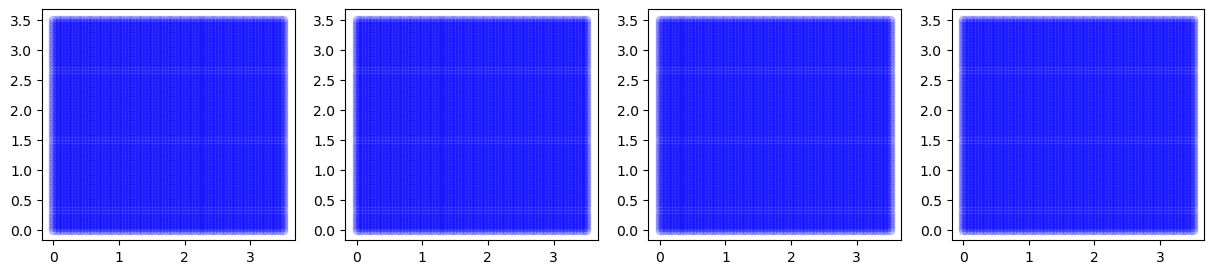

In [71]:
from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg.get_sample(10)
    for wi in weights:
        x_trunk, y_trunk, v_branch, t_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [72]:
sn.reset_session()
sn.set_random_seed(1234)

In [73]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       receiver_size=20,
                       embedding_size=20,
                       trunk_layers=7*[20],
                       sensor_branch_layers=7*[20],
                       receiver_branch_layers=7*[20],
                       root_layers=7*[20],
                       actf='tanh'):
        
        # velocity (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, sensor_branch_layers, actf, 'linear')
        
        # receiver branch net
        self.r_branch_inputs = [sn.Variable('rb', units=receiver_size)]
        self.r_branch_embedding = sn.Field('r_branch', units=embedding_size)
        self.r_branch = sn.Functional(self.r_branch_embedding, self.r_branch_inputs, receiver_branch_layers, actf, 'linear')
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, 'linear')
        
        self.root_inputs = [self.trunk * self.branch, 
                            self.trunk + self.branch, 
                            self.trunk - self.branch, 
                            self.trunk * self.r_branch,
                            self.trunk + self.r_branch,
                            self.trunk - self.r_branch,
                            # self.r_branch * self.branch, 
                            # self.r_branch + self.branch
                           ]
        
        self.output = sn.Functional('u', self.root_inputs, root_layers, actf)
        
        self.losses = [self.output]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=1e-4,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": os.path.join(ROOT_PATH, "weights"), "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [74]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    receiver_size=RECEIVER_SIZE,
    embedding_size=50,
    sensor_branch_layers=[100, 80, 50, 50],
    receiver_branch_layers=4*[50],
    trunk_layers=8*[50],
    root_layers=8*[50],
    actf='tanh'
)

In [75]:
list_weights = os.listdir(ROOT_PATH)
list_weights = list(sorted(filter(lambda x: x.startswith('weights-') and not x.startswith('weights-start'), list_weights)))
list_weights[-10:]

['weights-19200-2.188e-05.hdf5',
 'weights-19300-2.626e-05.hdf5',
 'weights-19400-2.137e-05.hdf5',
 'weights-19500-2.373e-05.hdf5',
 'weights-19600-2.549e-05.hdf5',
 'weights-19700-2.170e-05.hdf5',
 'weights-19800-2.293e-05.hdf5',
 'weights-19900-2.106e-05.hdf5',
 'weights-20000-2.224e-05.hdf5',
 'weights-end.hdf5']

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-00100-3.557e-03.hdf5
(70, 70)


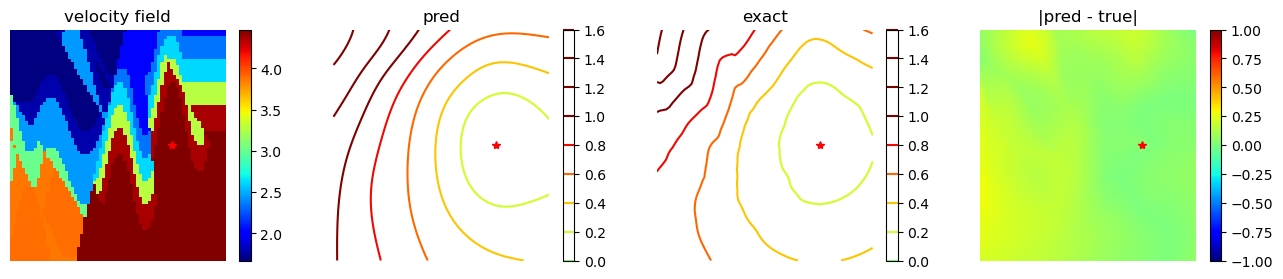

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-02100-6.614e-04.hdf5
(70, 70)


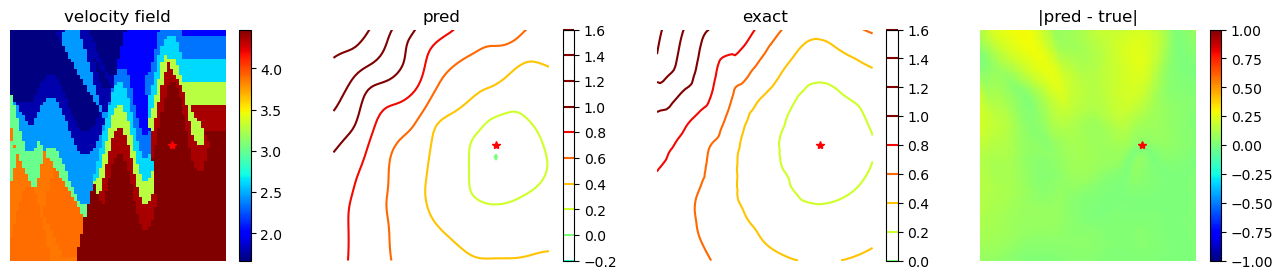

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-04100-1.068e-04.hdf5
(70, 70)


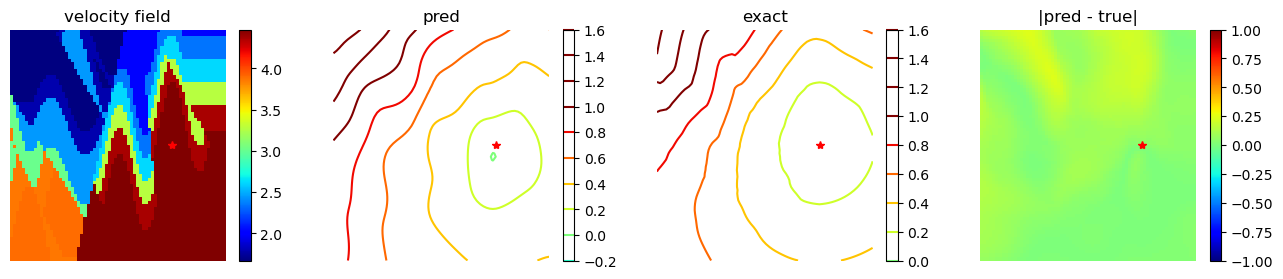

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-06100-4.684e-05.hdf5
(70, 70)


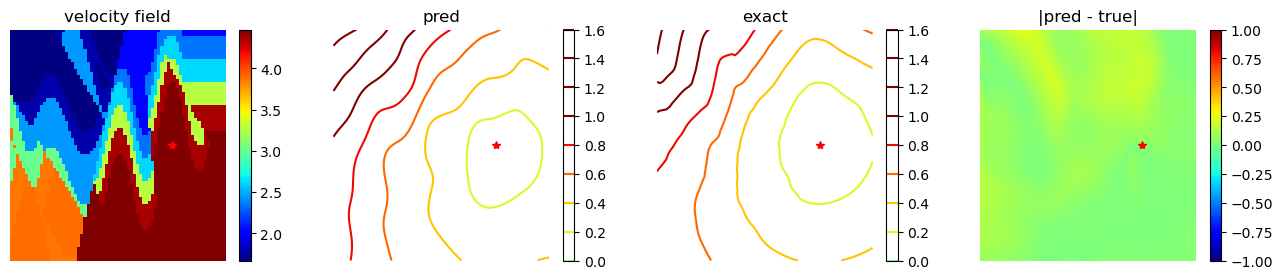

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-08100-3.336e-05.hdf5
(70, 70)


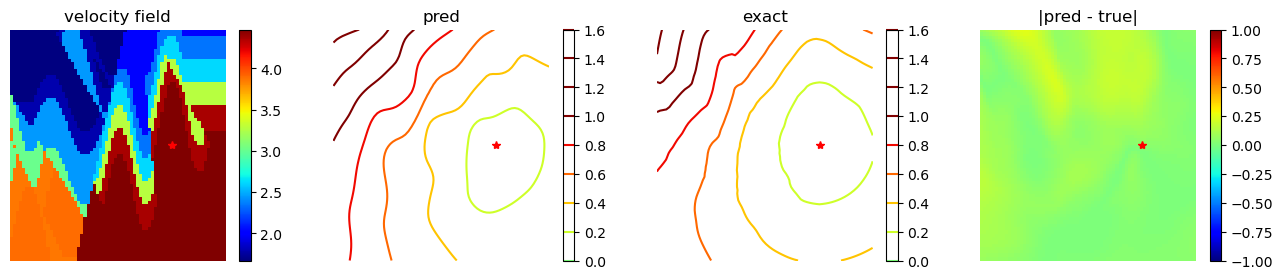

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-10100-3.159e-05.hdf5
(70, 70)


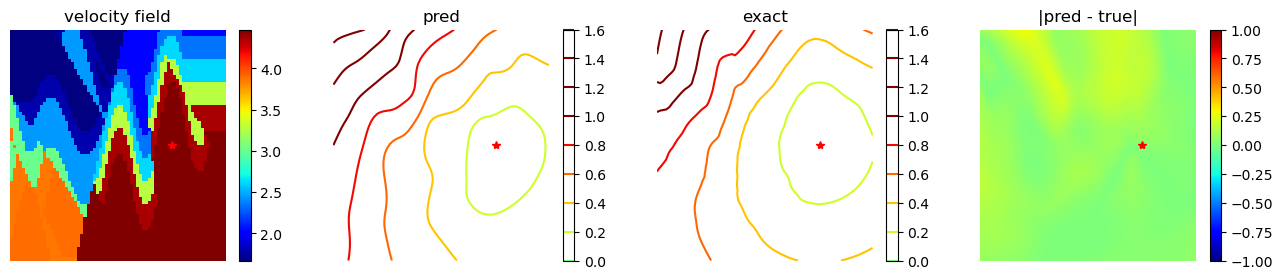

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-12100-2.702e-05.hdf5
(70, 70)


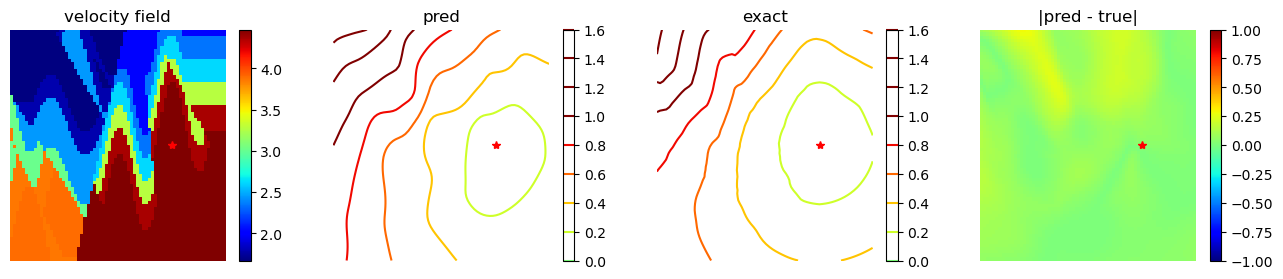

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-14100-2.428e-05.hdf5
(70, 70)


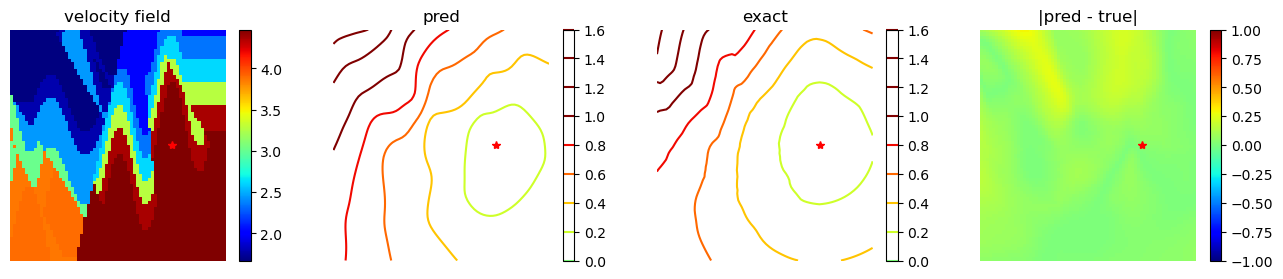

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-16100-2.701e-05.hdf5
(70, 70)


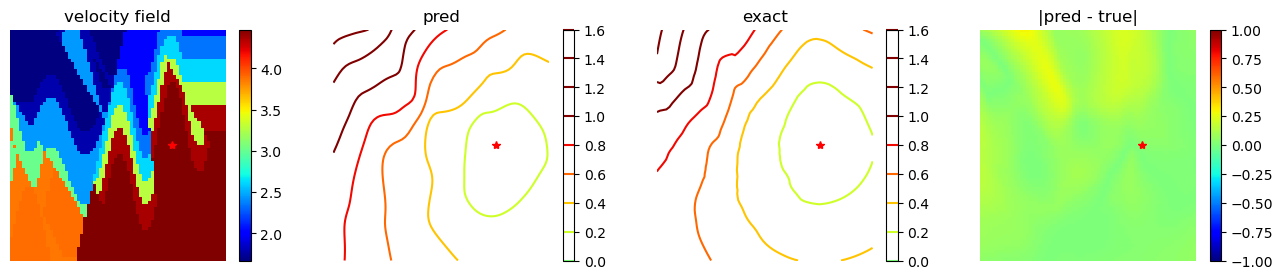

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-18100-2.322e-05.hdf5
(70, 70)


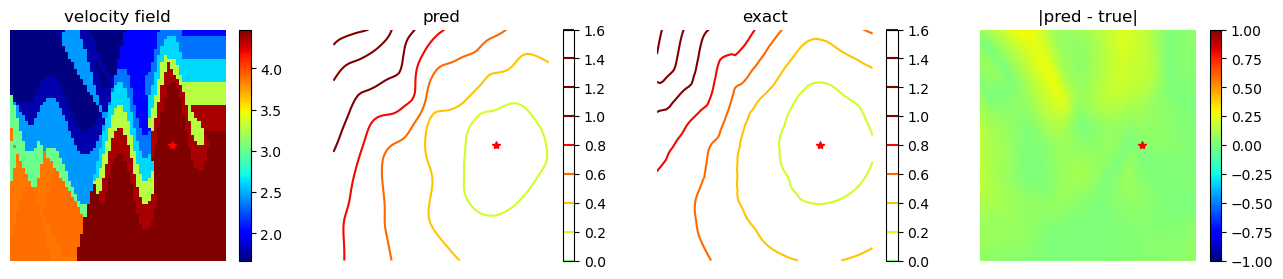

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/weights-end.hdf5
(70, 70)


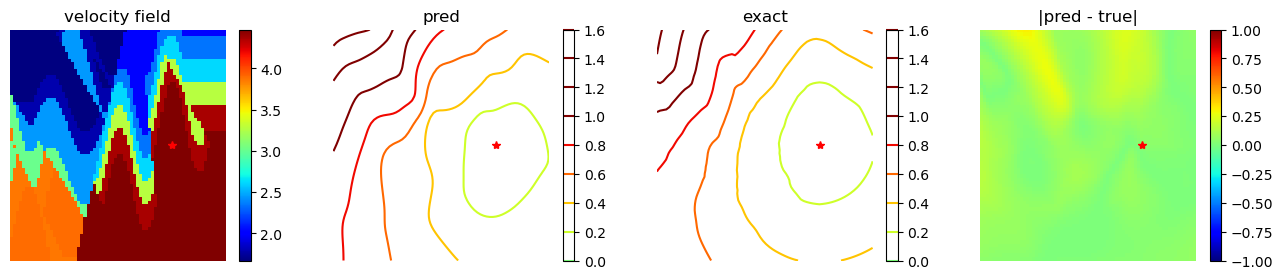

In [76]:
Nx, Ny = 70, 70

velocity = vel_models[np.random.choice(len(vel_models)), 0]
x_source = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
y_source = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)

test_data, vel_data, target_data = dg.generate_test_data(
    x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

x_test = test_data[0].reshape(Nx, Ny)
y_test = test_data[1].reshape(Nx, Ny)
v_test = np.copy(velocity)
exact = target_data.reshape(Nx, Ny)

# print(x_test.shape, y_test.shape, v_test.shape)

np.random.seed(12345)
for weight in list_weights[::int(len(list_weights)/10)]:
    weight_path = os.path.join(ROOT_PATH, weight)
    print('loading ... ', weight_path)
    DON.model.load_weights(weight_path)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    
    print(pred.shape)

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    
    ax0 = ax[0].pcolor(x_test, y_test, v_test.T, cmap='jet')
    ax[0].set_title('velocity field')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    
    ax1 = ax[1].contour(x_test, y_test, pred.T, cmap='jet', vmin=-1, vmax=1)
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact.T, cmap='jet', vmin=-1, vmax=1)
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact).T, cmap='jet', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    for ax_i in ax:
        ax_i.invert_yaxis()
        ax_i.plot(y_source, x_source, '*r')
    
    plt.show()

In [77]:
if 'weights-end.hdf5' in list_weights:
    weight_path = os.path.join(ROOT_PATH, 'weights-end.hdf5')
else:
    weight_path = os.path.join(ROOT_PATH, list_weights[-2])
DON.model.load_weights(weight_path)

In [78]:
def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet',
                xlabel=True, ylabel=False, vmin=None, vmax=None):
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(ax1, ax=AX)
    if Xs != None and Ys!=None:
        AX.scatter(Xs, Ys, marker='*', color='r')
    AX.set_title(title)
    AX.set_xticks(np.linspace(XMIN, XMAX, 8))
    AX.set_yticks(np.linspace(YMIN, YMAX, 8))
    if xlabel: AX.set_xlabel('Offset (km)')
    if ylabel: AX.set_ylabel('Depth (km)')
    AX.invert_yaxis()

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-pub.png


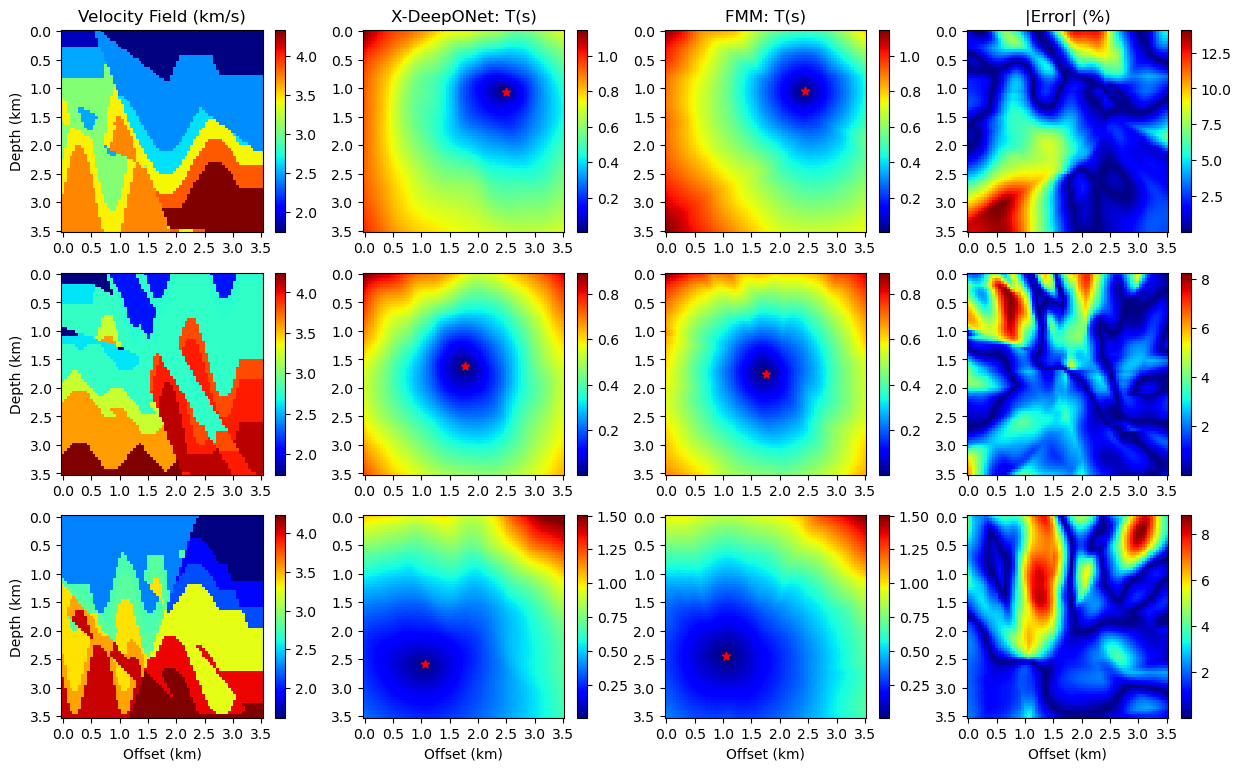

In [79]:
Nx, Ny = 70, 70

np.random.seed(123234)

fig, ax = plt.subplots(3, 4, figsize=(13, 8))
    
for i, (xi, eta) in enumerate([(0.3, 0.7), (0.5, 0.5), (0.7, 0.3)]):
    
    #velocity = vel_models[np.random.choice(len(vel_models)), 0]
    velocity = vel_models[300 + i*30 + 50, 0]
    x_source = XMIN + xi*DELTAX
    y_source = YMIN + eta*DELTAY
    
    
    test_data, vel_data, target_data = dg.generate_test_data(
        x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = np.copy(velocity)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[j_source, i_source]
    y_source_pred = y_test[j_source, i_source]
    
    error = abs(pred - exact) / exact.max() * 100
    
    cust_pcolor(ax[i, 0], x_test, y_test, v_test.T, title='Velocity Field (km/s)' if i==0 else None,
                cmap='jet', ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, pred.T, x_source_pred, y_source_pred, title='X-DeepONet: T(s)' if i==0 else None,
                cmap='jet', vmin=exact.min(), vmax=exact.max(), xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 2], x_test, y_test, exact.T, y_source, x_source, title='FMM: T(s)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 3], x_test, y_test, error.T, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

    
plt.subplots_adjust(0.08, 0.08, 0.97, 0.94, 0.2, 0.2)
print('Saving to: ', os.path.join(ROOT_PATH, 'vel-pred-pub.png'))
plt.savefig(os.path.join(ROOT_PATH, 'vel-pred-pub.png'))
plt.show()


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-0.png


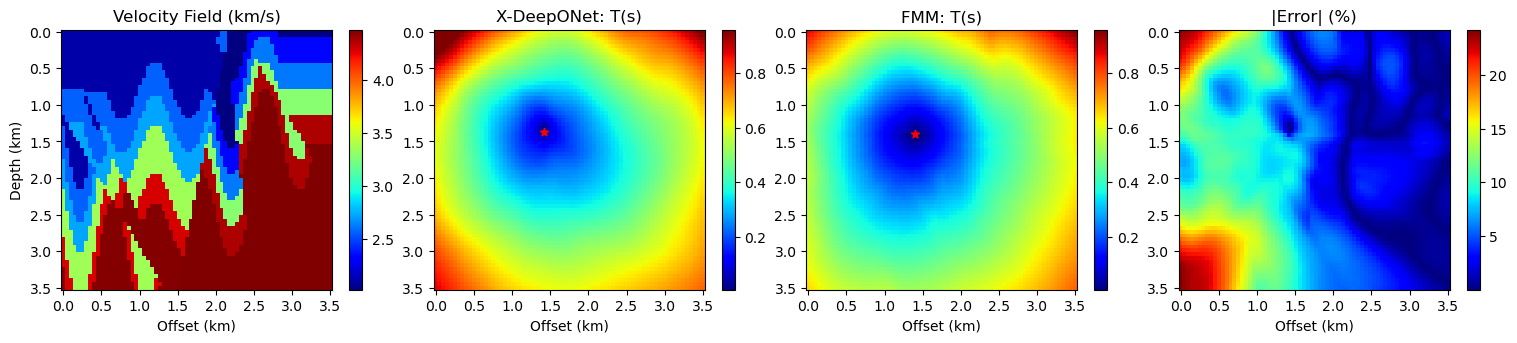

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-1.png


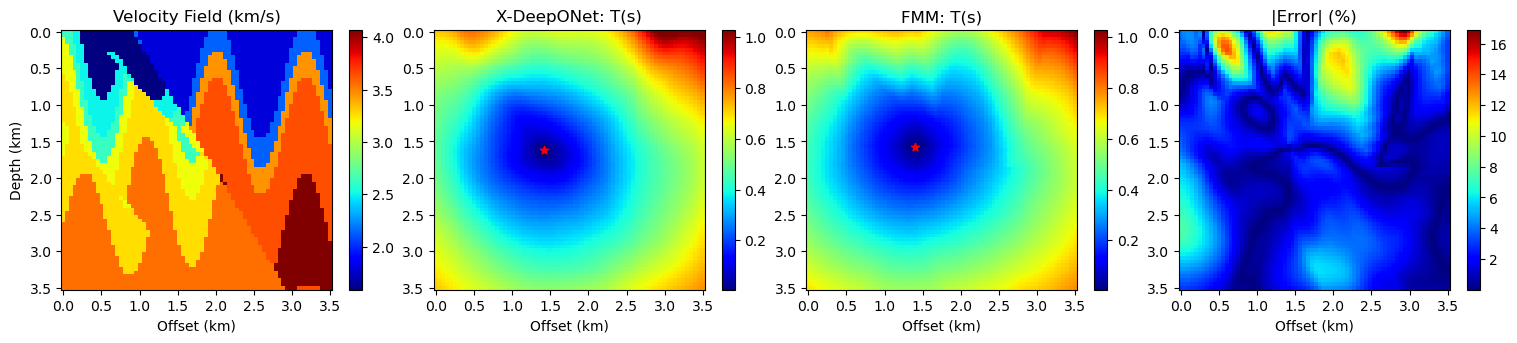

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-2.png


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-3.png


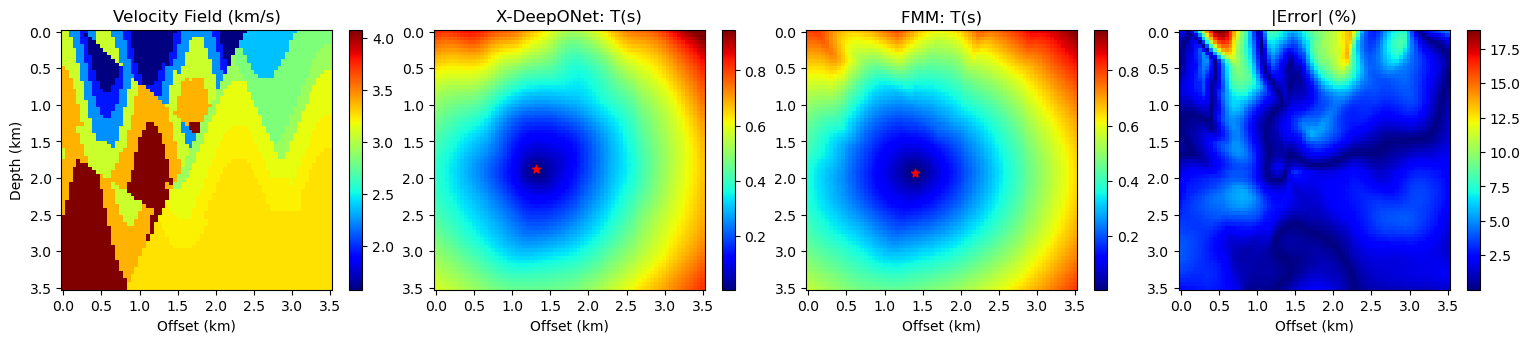

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-4.png


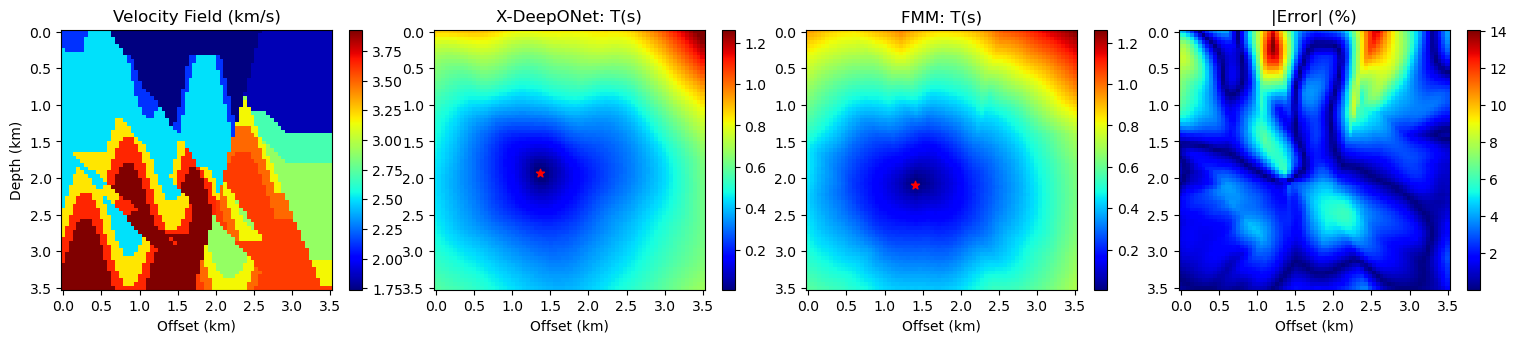

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-5.png


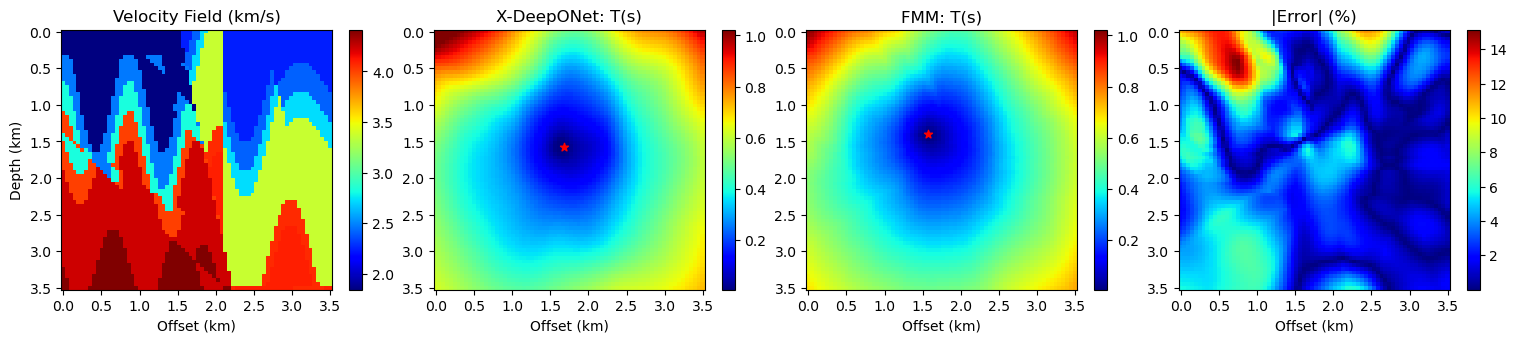

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-6.png


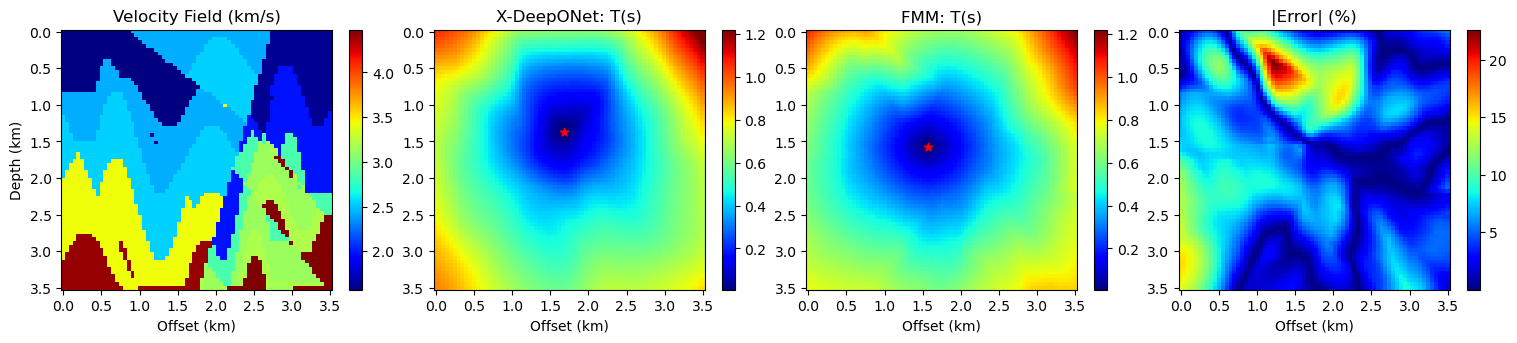

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-7.png


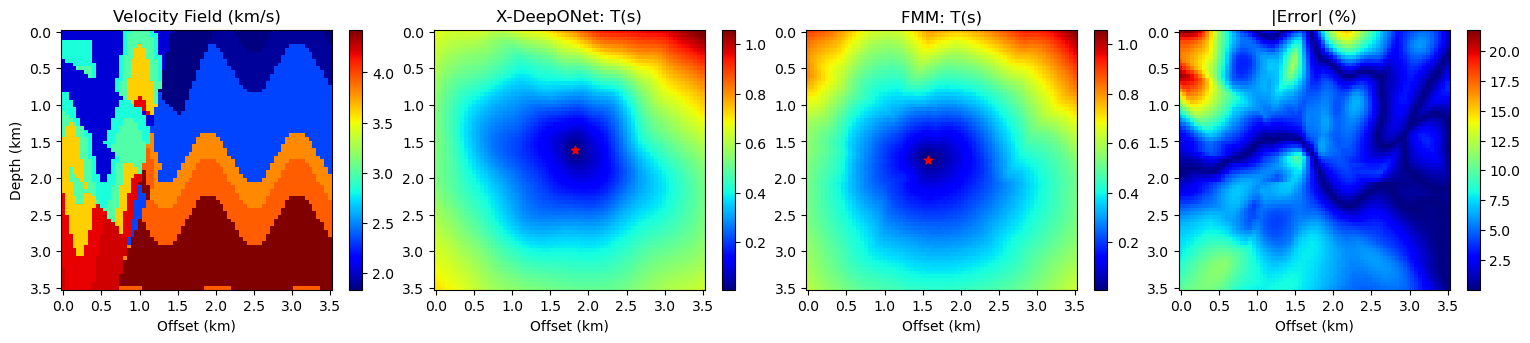

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-8.png


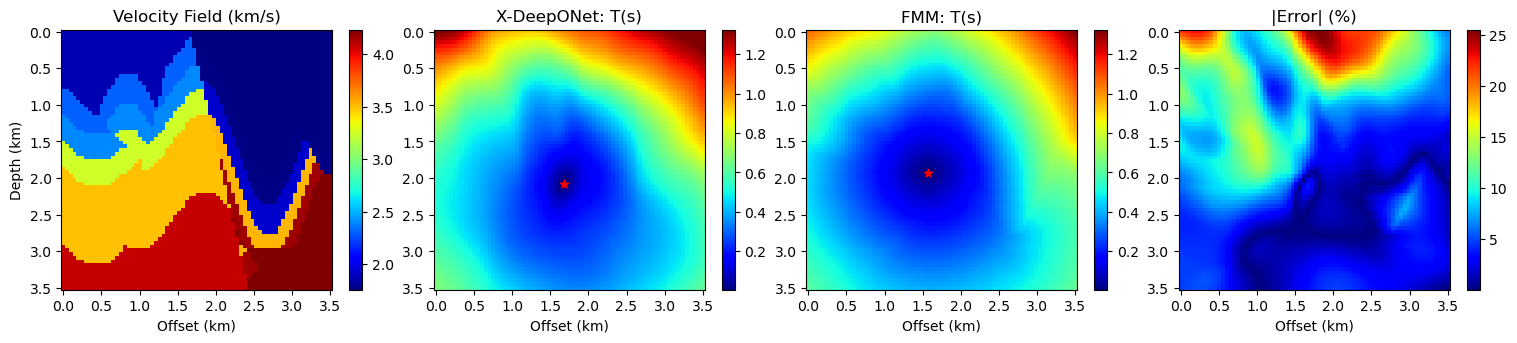

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-9.png


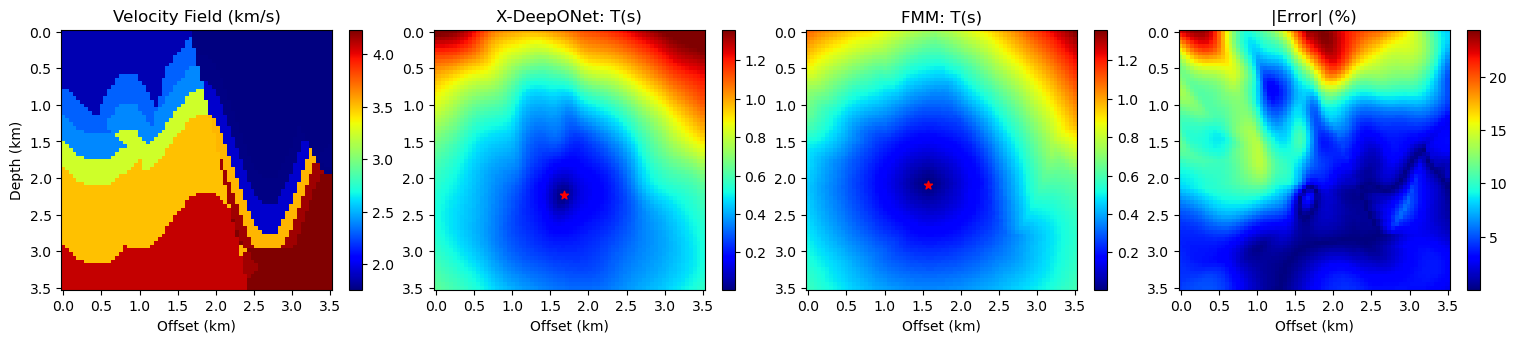

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-10.png


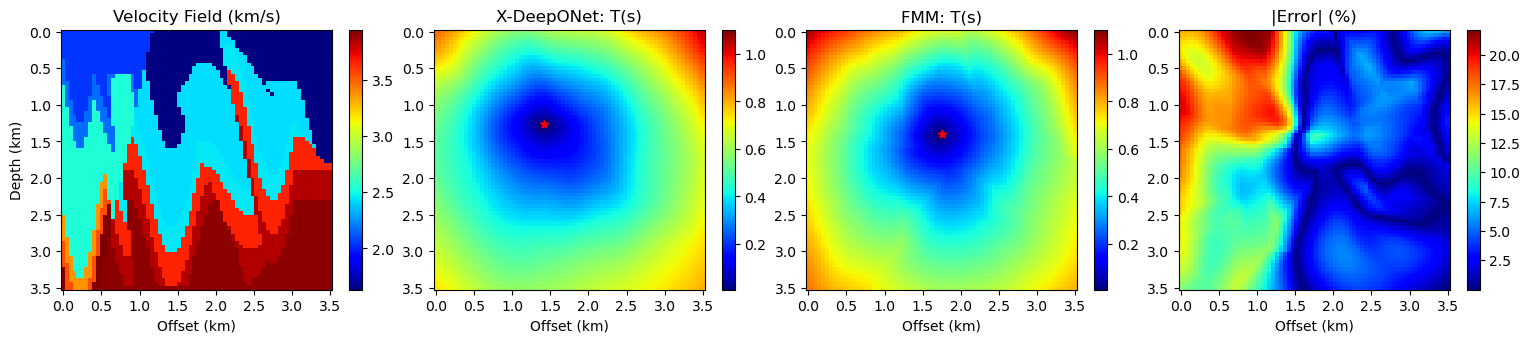

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-11.png


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-12.png


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-13.png


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-14.png


Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-15.png


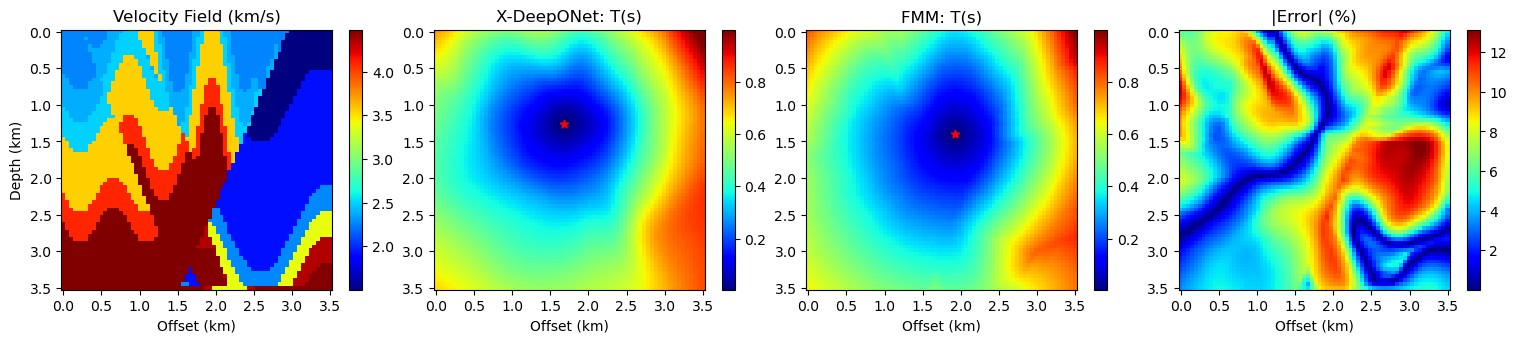

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-16.png


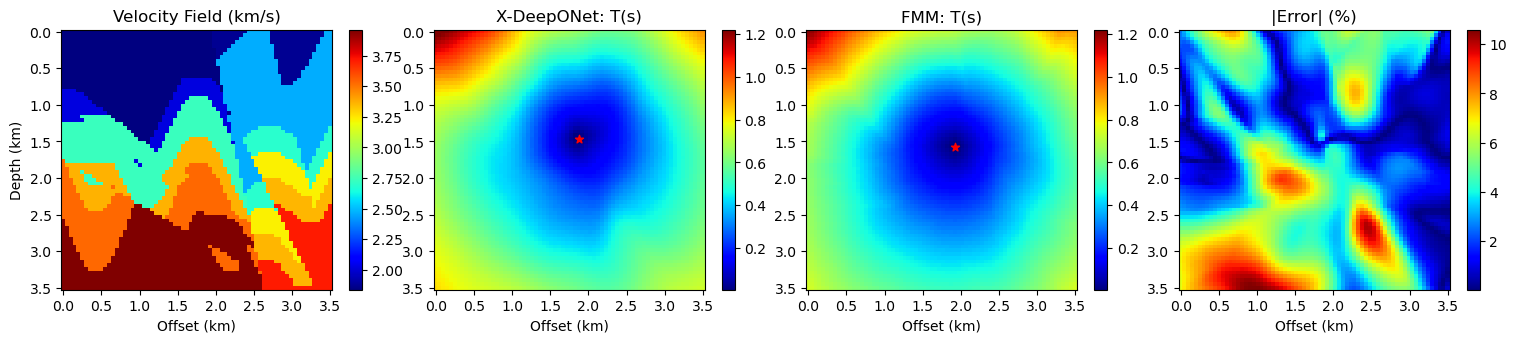

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-17.png


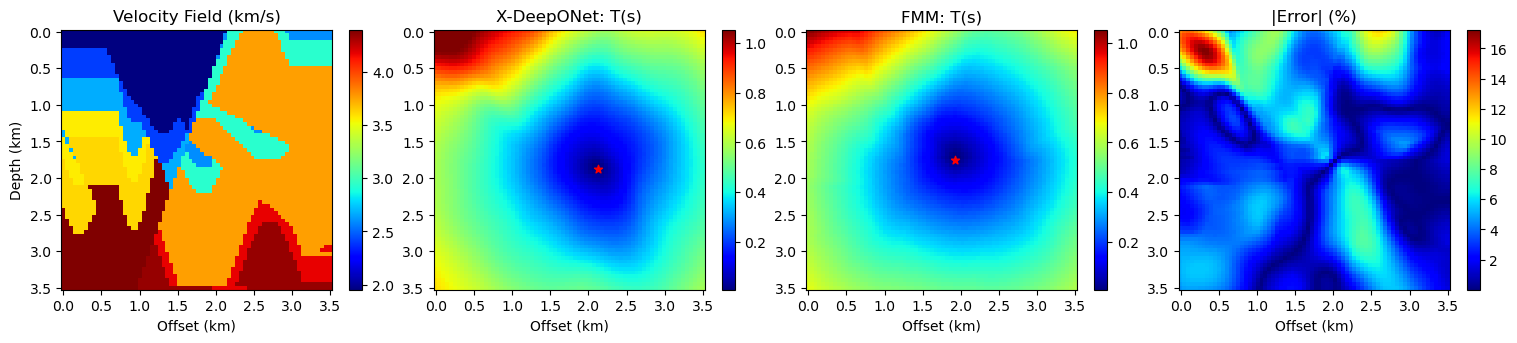

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-18.png


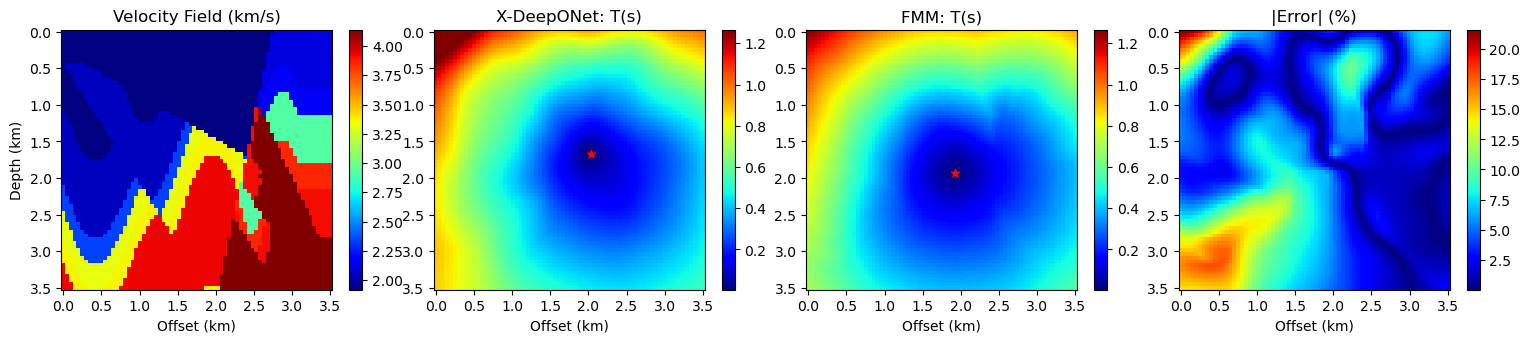

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-19.png


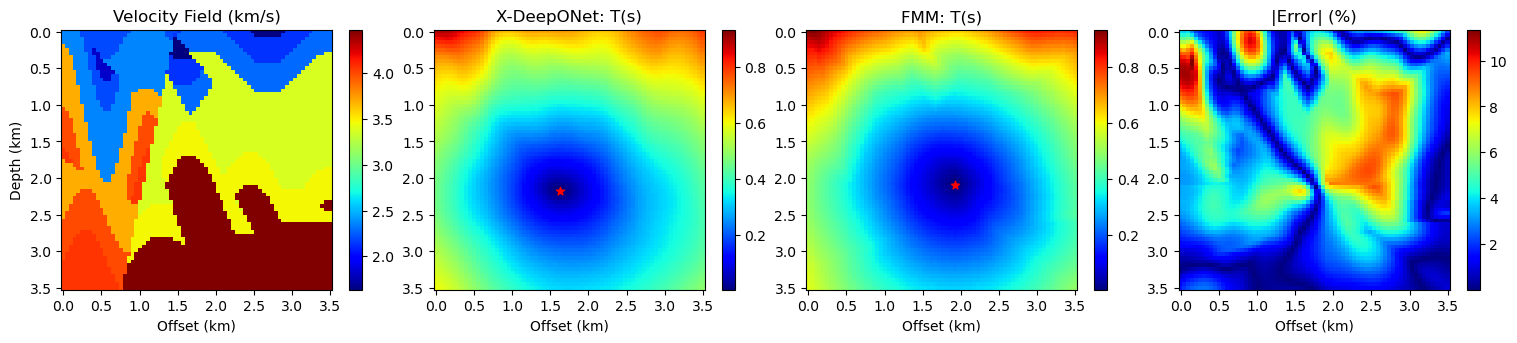

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-20.png


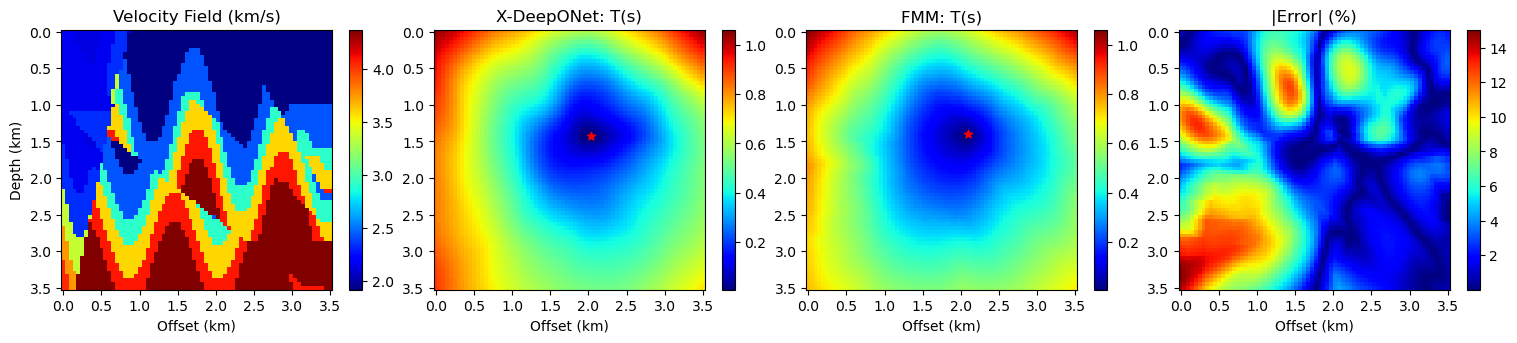

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-21.png


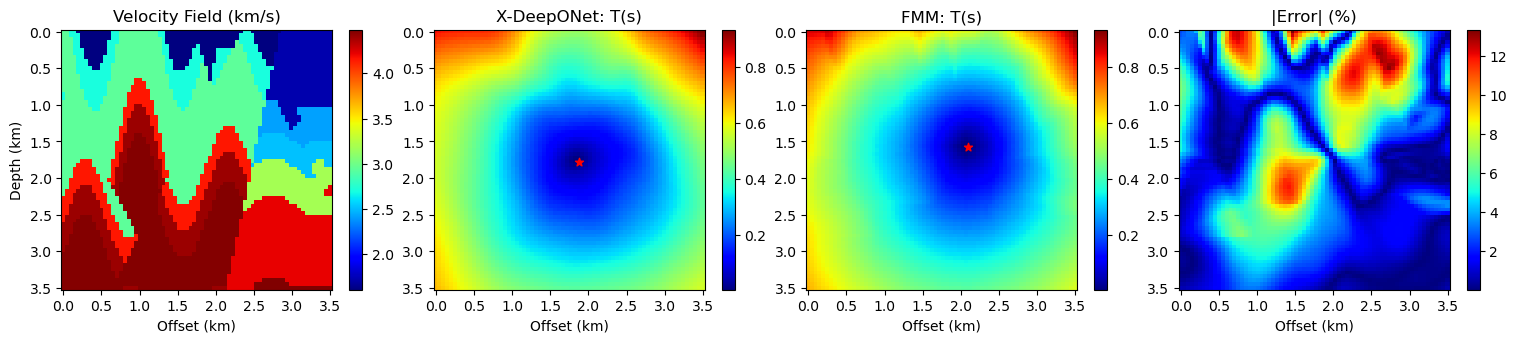

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-22.png


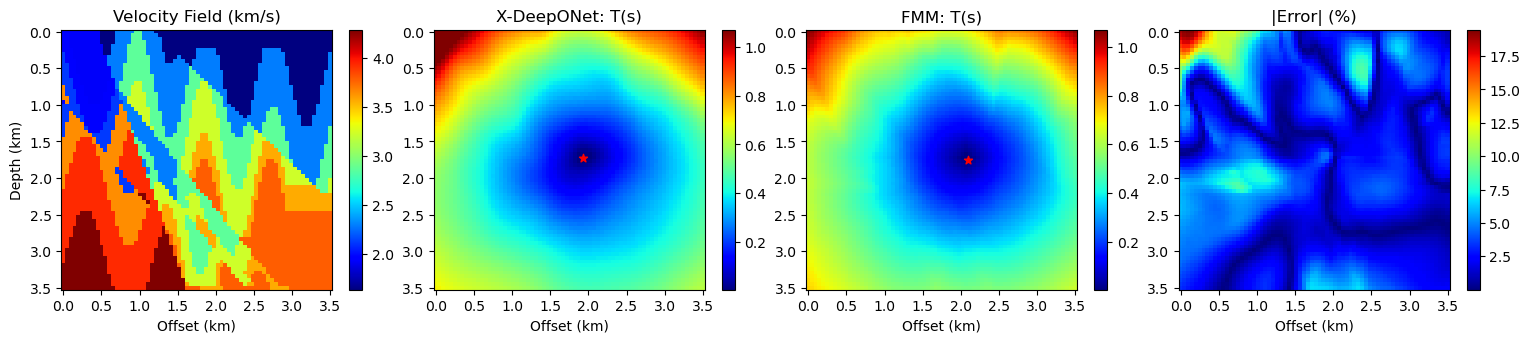

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-23.png


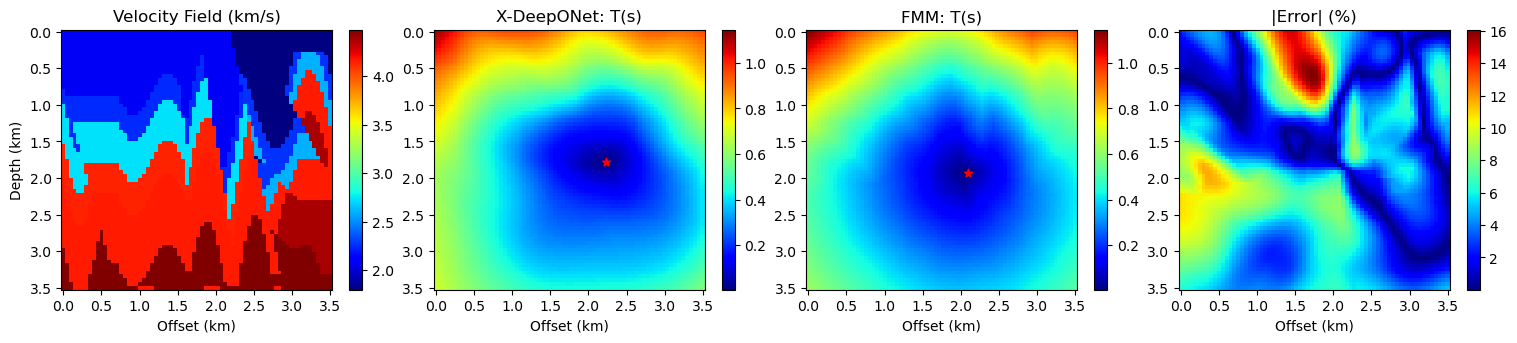

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/vel-pred-24.png


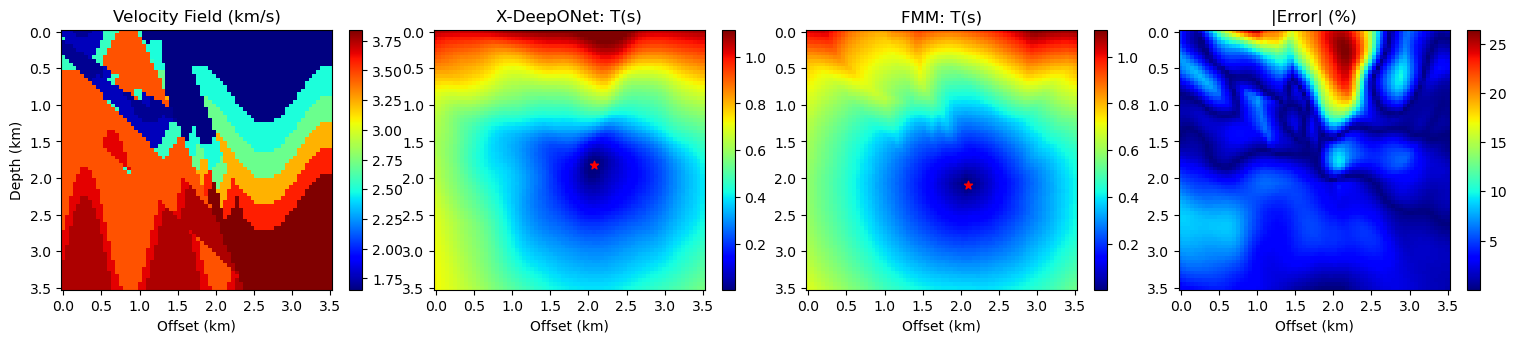

In [80]:
Nx, Ny = 70, 70

np.random.seed(123234)

x_sources, y_sources = np.meshgrid(
    np.linspace(XMIN+0.4*DELTAX, XMAX-0.4*DELTAX, 5),
    np.linspace(YMIN+0.4*DELTAY, YMAX-0.4*DELTAY, 5)
)

for i in range(x_sources.size):
    velocity = vel_models[np.random.choice(len(vel_models)), 0]
    x_source = x_sources.flatten()[i] #np.random.uniform(XMIN+0.2*DELTAX, XMAX-0.2*DELTAX)
    y_source = y_sources.flatten()[i] #np.random.uniform(YMIN+0.2*DELTAY, YMAX-0.2*DELTAY)
    
    
    test_data, vel_data, target_data = dg.generate_test_data(
        x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = np.copy(velocity)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[j_source, i_source]
    y_source_pred = y_test[j_source, i_source]
    
    error = abs(pred - exact) / exact.max() * 100
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    
    cust_pcolor(ax[0], x_test, y_test, v_test.T, title='Velocity Field (km/s)', cmap='jet', ylabel=True)
    cust_pcolor(ax[1], x_test, y_test, pred.T, x_source_pred, y_source_pred, title='X-DeepONet: T(s)', cmap='jet', vmin=exact.min(), vmax=exact.max())
    cust_pcolor(ax[2], x_test, y_test, exact.T, y_source, x_source, title='FMM: T(s)', cmap='jet')
    cust_pcolor(ax[3], x_test, y_test, error.T, title='|Error| (%)', cmap='jet')
    
    plt.subplots_adjust(0.07, 0.2, 0.98, 0.85, 0.1, 0.1)
    print('Saving to: ', os.path.join(ROOT_PATH, f'vel-pred-{i}.png'))
    plt.savefig(os.path.join(ROOT_PATH, f'vel-pred-{i}.png'))
    
    plt.show()
    # break

 trial 0 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-0.png


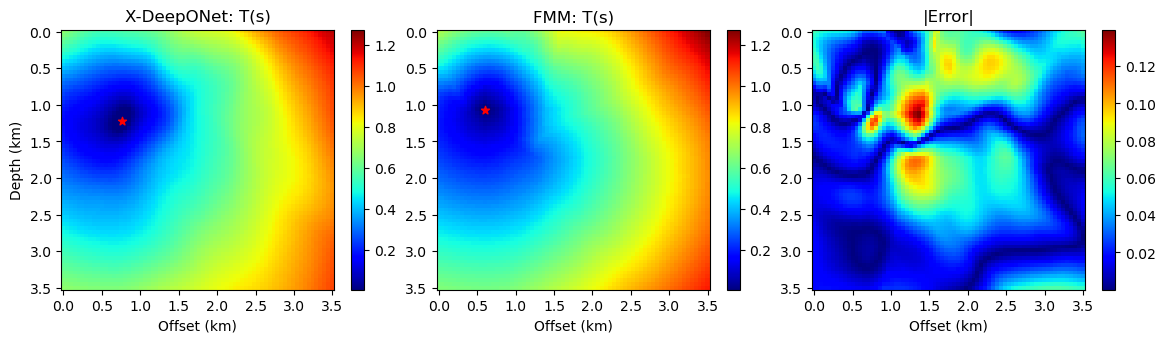

 trial 10 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-10.png


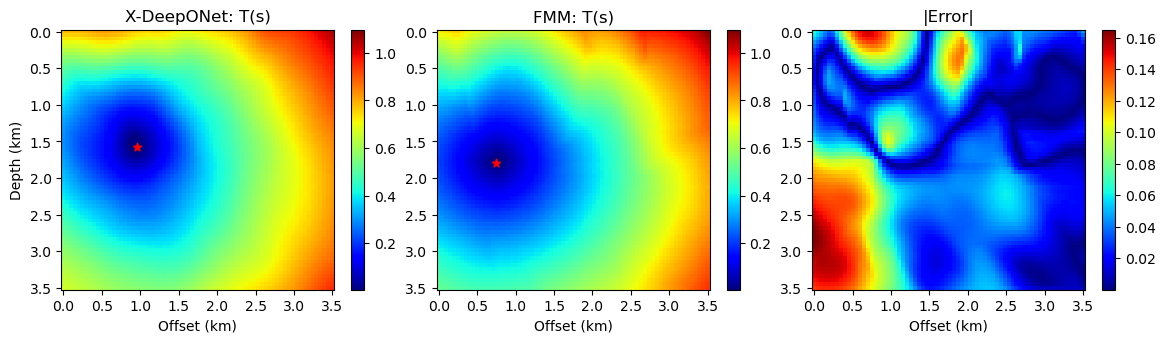

 trial 20 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-20.png


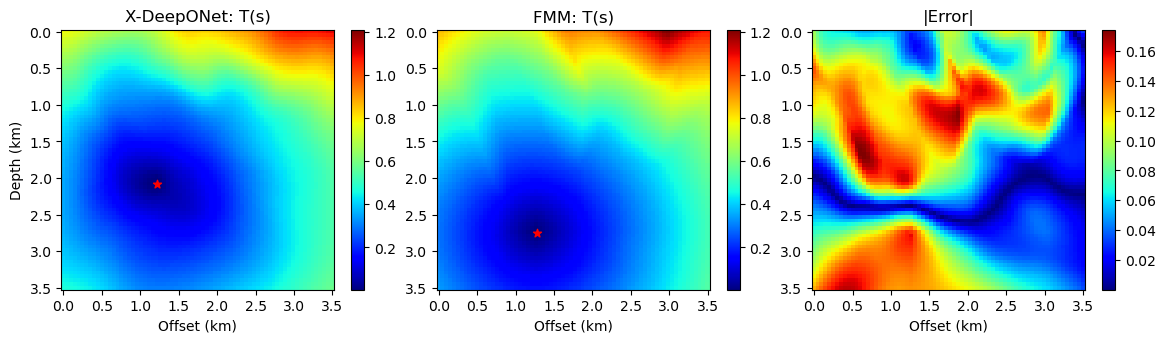

 trial 30 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-30.png


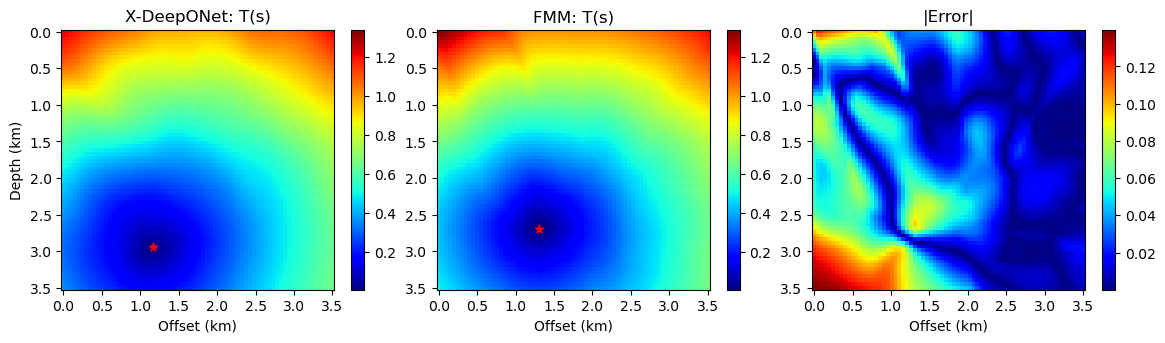

 trial 40 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-40.png


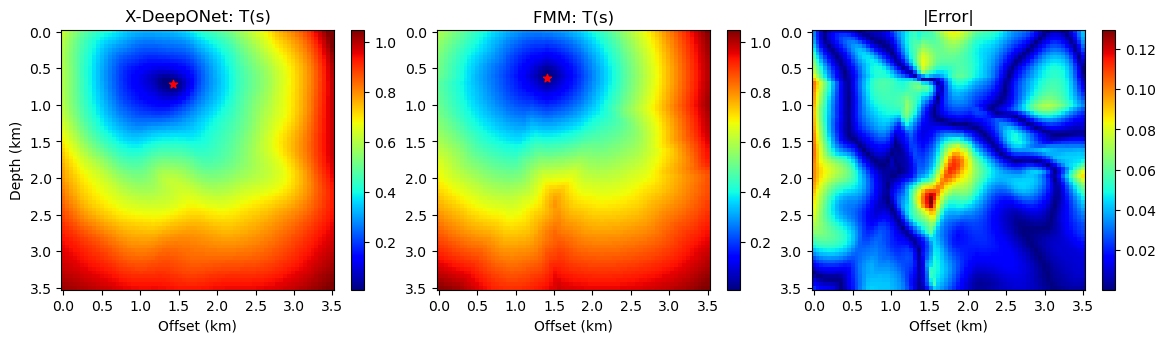

 trial 50 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-50.png


 trial 60 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-60.png


 trial 70 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-70.png


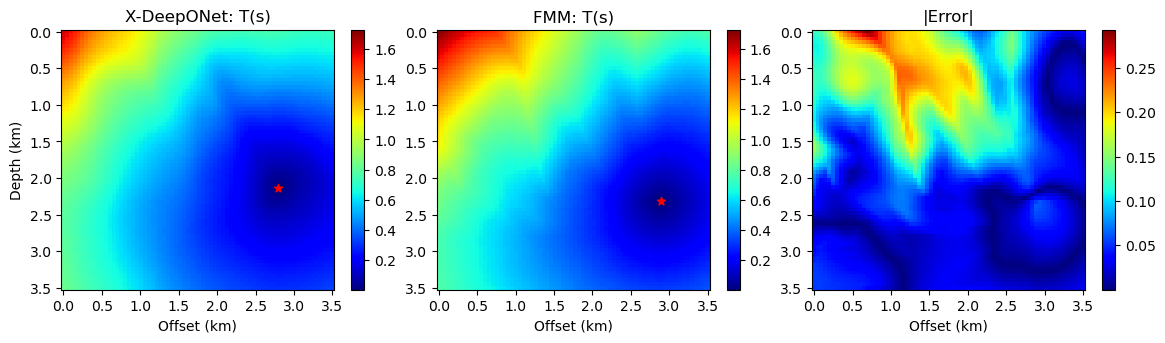

 trial 80 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-80.png


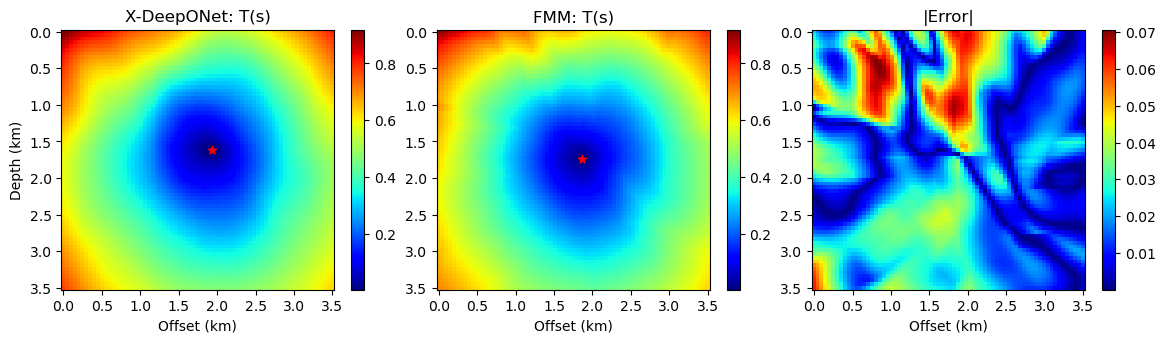

 trial 90 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-90.png


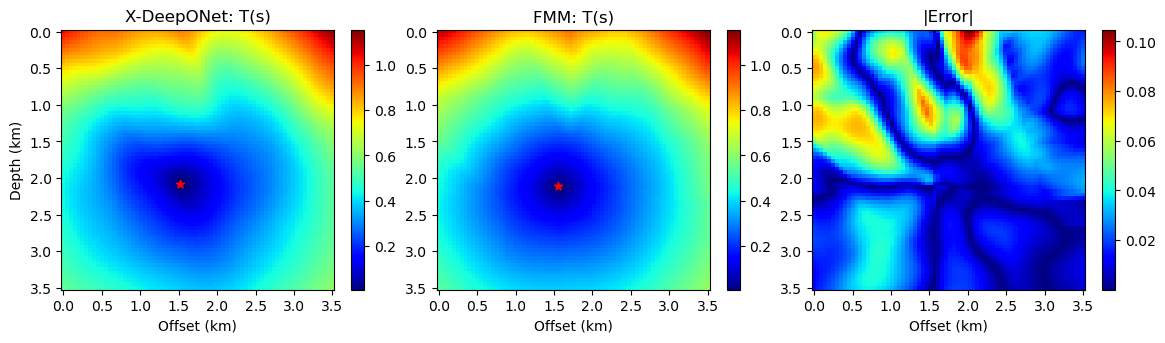

 trial 100 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-100.png


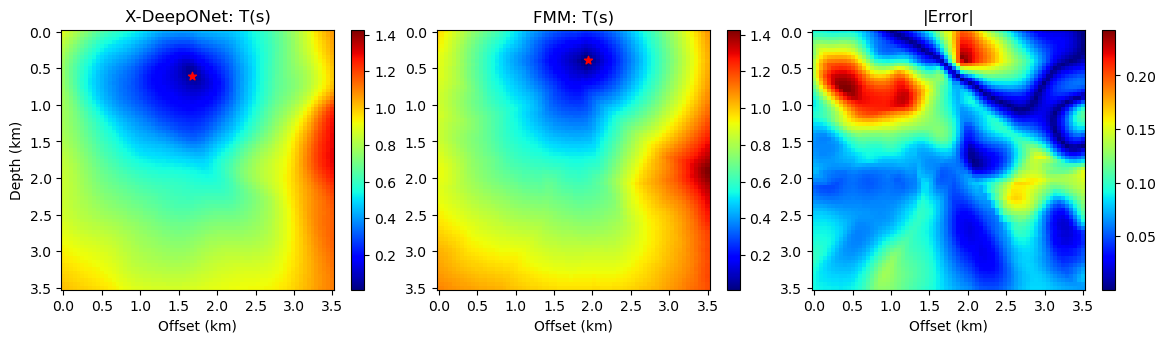

 trial 110 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-110.png


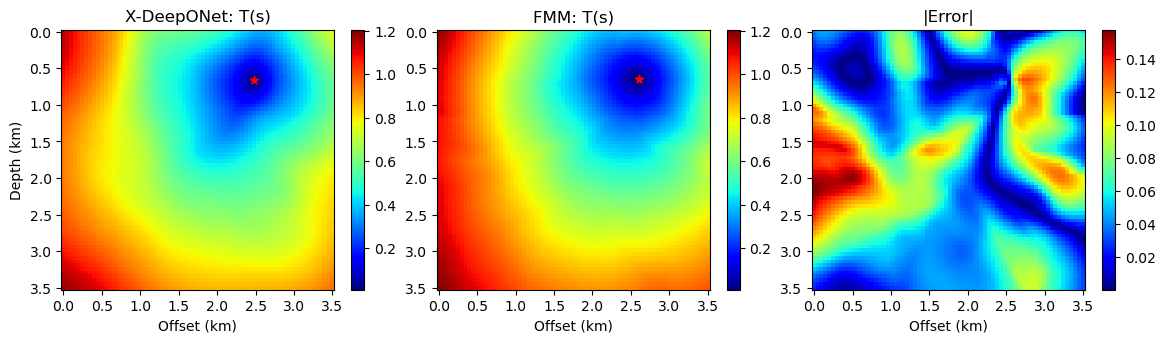

 trial 120 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-120.png


 trial 130 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-130.png


 trial 140 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-140.png


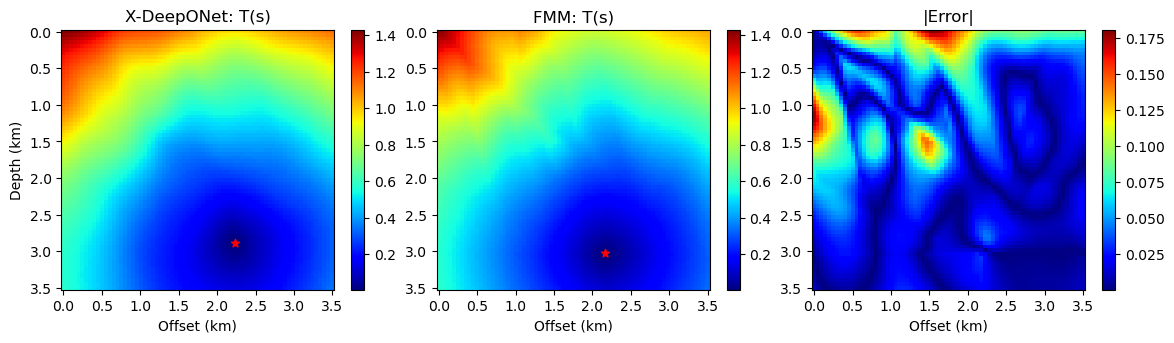

 trial 150 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-150.png


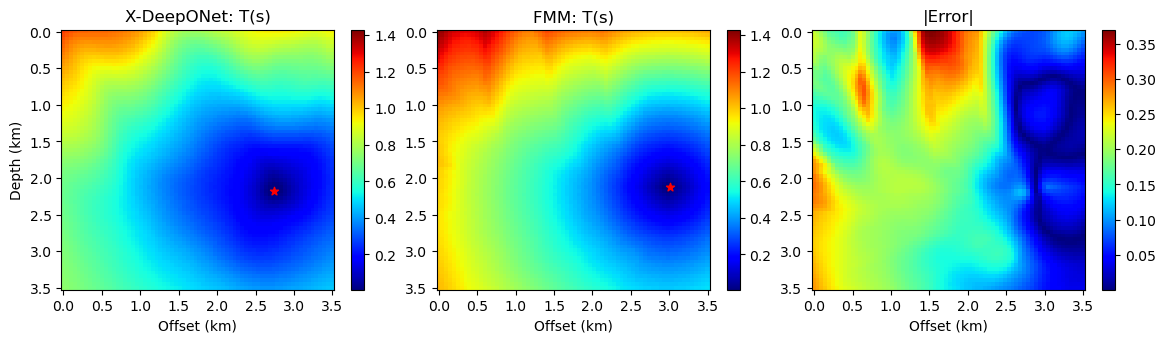

 trial 160 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-160.png


 trial 170 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-170.png


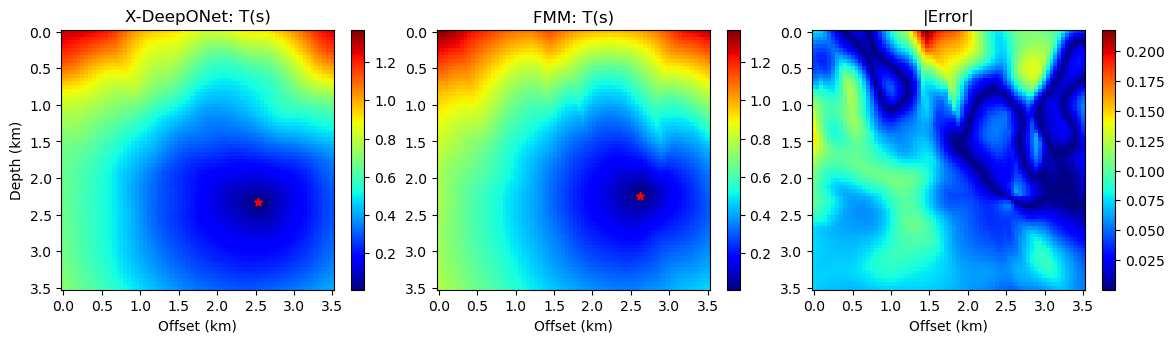

 trial 180 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-180.png


 trial 190 / 200
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2-OpenFWI7/pred-190.png


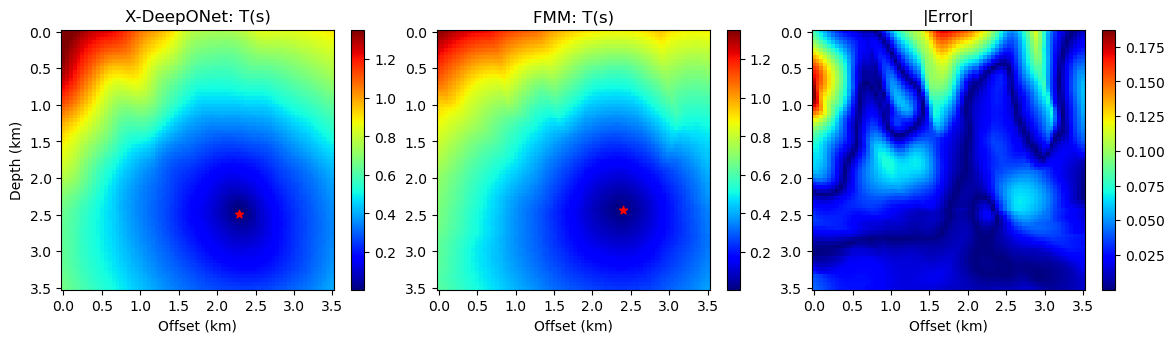

In [81]:
Nx, Ny = 70, 70

rmse_error = []
source_locs = []
source_error = []

NUM_TRIAL = 200
for i in range(NUM_TRIAL):  
    velocity = vel_models[300+i, 0]
    x_source = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
    y_source = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)

    
    test_data, vel_data, target_data = dg.generate_test_data(
        x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    
    exact = target_data.reshape(Nx, Ny).T
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny).T
    
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]

    rmse_error.append(np.sqrt(np.mean((pred - exact)**2)))
    source_locs.append([x_source, y_source])
    
    source_error.append(
        [x_source-y_source_pred, y_source-x_source_pred]
    )


    if i % int(NUM_TRIAL/20) == 0:
        print(f' trial {i} / {NUM_TRIAL}')
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
        # ax[0].set_title('velocity field')
        # ax[0].axis('off')
        # plt.colorbar(ax0, ax=ax[0])
        ax = [None, ax[0], ax[1], ax[2]]
        
        cust_pcolor(ax[1], x_test, y_test, pred, x_source_pred, y_source_pred, title='X-DeepONet: T(s)', 
                    cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True)
        cust_pcolor(ax[2], x_test, y_test, exact, y_source, x_source, title='FMM: T(s)', cmap='jet')
        cust_pcolor(ax[3], x_test, y_test, abs(pred - exact), title='|Error|', cmap='jet')
        plt.subplots_adjust(0.07, 0.2, 0.98, 0.85, 0.1, 0.1)
        print('Saving to: ', os.path.join(ROOT_PATH, f'pred-{i}.png'))
        plt.savefig(os.path.join(ROOT_PATH, f'pred-{i}.png'))
        plt.show()
        # break

    # raise ValueError

In [83]:
print(pred.min())
i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
pred[i_source, j_source]

0.008413927


0.008413927

In [84]:
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
plt.figure(figsize=(4,3))
plt.hist(rmse_error, 20, weights=weights)
plt.xlabel('RMSE (s)')
plt.ylabel('%')
plt.tight_layout()
# plt.xlim(0., 0.2)
plt.savefig(os.path.join(ROOT_PATH, 'ekional_source_error_distribution.pdf'))

In [85]:
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = [ax]
# ax[0].hist(rmse_error, 20, weights=weights, alpha=0.6, label='RMSE(T)')
ax[0].hist(abs(source_error[:, 0]), 20, weights=weights, alpha=0.6, label='x-source')
ax[0].hist(abs(source_error[:, 1]), 20, weights=weights, alpha=0.6, label='y-source')
ax[0].set_xlabel('Absolute Error (km)')
# ax[0].set_xlim(-0.5, 0.5)
# ax[0].set_xlabel('y-source')
# ax[0].set_xlim(0., 0.3)
ax[0].set_ylabel('%')
ax[0].set_ylabel('%')
plt.tight_layout()
plt.legend(loc='upper right')
# plt.show()
plt.savefig(os.path.join(ROOT_PATH, 'ekional_XY-source_error_distribution.pdf'))

In [86]:
Nx, Ny = 70, 70

noise_vals =  [0.01, 0.1, 0.2, 0.5]
noise_error = []
noise_source_error = []
NUM_TRIAL2 = 200
for noise in noise_vals:
    rmse_error2 = []
    source_error2 = []
    for i in range(NUM_TRIAL2):
        velocity = vel_models[300+i, 0]
        x_source = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
        y_source = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)

        test_data, vel_data, target_data = dg.generate_test_data(
            x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)

        x_test = test_data[0].reshape(Nx, Ny)
        y_test = test_data[1].reshape(Nx, Ny)
        v_test = vel_data.reshape(Nx, Ny)
        exact = target_data.reshape(Nx, Ny)

        pred = DON.eval_u(test_data).reshape(Nx, Ny)
        
        i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
        x_source_pred = x_test[i_source, j_source]
        y_source_pred = y_test[i_source, j_source]
        
        rmse_error2.append(np.sqrt(np.mean((pred - exact)**2)))
        source_error2.append(
            [x_source-y_source_pred, y_source-x_source_pred]
        )

            
    print(f'done with noise = {noise}')
    noise_error.append(rmse_error2)
    noise_source_error.append(source_error2)

done with noise = 0.01
done with noise = 0.1
done with noise = 0.2
done with noise = 0.5


In [87]:
noise_source_error = np.array(noise_source_error)
noise_error = np.array(noise_error)
noise_Xsource_error = noise_source_error[:,:,0]
noise_Ysource_error = noise_source_error[:,:,1]

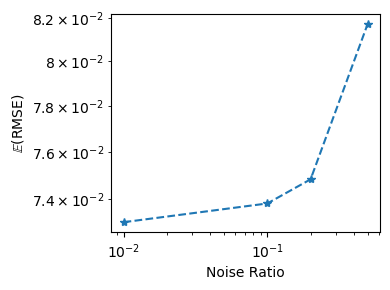

In [93]:
plt.figure(figsize=(4,3))
plt.loglog(noise_vals, np.mean(noise_error, axis=-1), '--*')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$(RMSE)')
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'ekional_source_noise_sensitivity.pdf'))

In [92]:
plt.figure(figsize=(4,3))
plt.semilogx(noise_vals, abs(noise_Xsource_error).mean(axis=-1), '--*', label='x-source')
plt.semilogx(noise_vals, abs(noise_Ysource_error).mean(axis=-1), '--*', label='y-source')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$ |Error| (km)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(ROOT_PATH, 'ekional_XY-source_noise_sensitivity.pdf'))

In [91]:
Nx, Ny = 70, 70

fig = plt.figure(figsize=(5, 3))
np.random.seed(1234)

velocity = vel_models[np.random.choice(len(vel_models)), 0]
x_source = (XMIN + XMAX)/2
y_source = (YMIN + YMAX)/2

# v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
# x_source, y_source = [0.5, 0.5]

sensor_id = np.arange(1, RECEIVER_SIZE+1, 1, dtype=int)
# print(sensor_id)

test_data, vel_data, target_data = dg.generate_test_data(
    x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
plt.plot(sensor_id, test_data[3][0, :], '-ok', lw=2, ms=6)

    
for noise in [0.01, 0.1, 0.2, 0.5]:
    for i in range(1):
        test_data, vel_data, target_data = dg.generate_test_data(
            x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)
        plt.plot(sensor_id, test_data[3][0, :], '-', label=f'NR={noise}', alpha=0.5)
        

plt.ylabel('Receiver Arrival Time (s)')
plt.xlabel('sensor-id')
plt.xticks(np.arange(1, RECEIVER_SIZE+1, 2))
# plt.ylim(0, 1)
plt.tight_layout()
plt.legend(title='noise ratio', loc='upper right', frameon=False)
plt.savefig(os.path.join(ROOT_PATH, 'recevier-noise-realizations.pdf'))